In [47]:
#Import relevant libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

#Loading of data 
df = pd.read_excel('../data/sds_datathon_gradsingapore.xlsx')
print(df.head())
print(df.columns)
#data loaded successfully

   Response ID        Time Started      Date Submitted        Status Language  \
0           19 2025-09-02 15:03:01 2025-09-02 15:03:40       Partial  English   
1           20 2025-09-02 15:15:32 2025-09-02 15:16:59  Disqualified  English   
2           21 2025-09-02 15:18:01 2025-09-02 15:19:30  Disqualified  English   
3           22 2025-09-03 15:25:18 2025-09-03 15:27:05      Complete  English   
4           23 2025-09-03 15:34:31 2025-09-03 15:34:31       Partial  English   

                            SessionID  \
0  1756796577_68b696a123dd27.81295289   
1  1756797328_68b699901c4cf6.89118890   
2  1756797478_68b69a26c5d785.44808899   
3  1756884314_68b7ed5a14f861.00788803   
4  1756884864_68b7ef80372683.27687311   

                                          User Agent  Tags      IP Address  \
0  Mozilla/5.0 (iPhone; CPU iPhone OS 18_6_2 like...   NaN  104.28.119.112   
1  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...   NaN    57.140.24.26   
2  Mozilla/5.0 (Windows NT 10.0;

In [48]:
# 1. Clean all column headers to remove invisible characters (\xa0) and extra spaces
df.columns = df.columns.str.replace('\xa0', ' ', regex=True).str.strip()

# 2. Automatically find all columns related to the "Pick 3" question
# This searches for any column containing that specific question text
pick_3_cols = [col for col in df.columns if "What do you wish to learn more about regarding the organisation as an employer? (Pick 3)" in col]

# 3. Print them out just to verify we found all 7
print(f"Found {len(pick_3_cols)} columns for consolidation.")

# 4. Improved consolidation logic
def get_interests(row):
    # We use pd.notna and ensure the value isn't just an empty string
    interests = [str(row[col]).strip() for col in pick_3_cols 
                 if pd.notna(row[col]) and str(row[col]).strip() != '']
    return ", ".join(interests) if interests else "None Selected"

# 5. Apply and verify
df['Student_Interest_Profile'] = df.apply(get_interests, axis=1)
print(df)

#Ok correct, theres now a new column with them as strings

Found 7 columns for consolidation.
      Response ID        Time Started      Date Submitted        Status  \
0              19 2025-09-02 15:03:01 2025-09-02 15:03:40       Partial   
1              20 2025-09-02 15:15:32 2025-09-02 15:16:59  Disqualified   
2              21 2025-09-02 15:18:01 2025-09-02 15:19:30  Disqualified   
3              22 2025-09-03 15:25:18 2025-09-03 15:27:05      Complete   
4              23 2025-09-03 15:34:31 2025-09-03 15:34:31       Partial   
...           ...                 ...                 ...           ...   
2609         2628 2025-11-13 11:04:35 2025-11-13 11:31:13      Complete   
2610         2629 2025-11-13 11:16:03 2025-11-13 11:19:03      Complete   
2611         2630 2025-11-13 13:02:23 2025-11-13 13:02:56       Partial   
2612         2631 2025-11-13 14:28:12 2025-11-13 14:29:54  Disqualified   
2613         2632 2025-11-13 19:18:39 2025-11-13 19:20:50      Complete   

     Language                           SessionID  \
0     Engli

In [49]:
#Time taken so we can remove the redundant columns time start and time end
#first convert to datetime format
df['Time Started'] = pd.to_datetime(df['Time Started'], errors='coerce')
df['Date Submitted'] = pd.to_datetime(df['Date Submitted'], errors='coerce')

df['Time Taken'] = df['Date Submitted'] - df['Time Started']
df['Time Taken'] = df['Time Taken'].dt.total_seconds() / 60  # Convert to minutes

# Now we can drop the original time columns
df = df.drop(columns=['Time Started', 'Date Submitted'])

#handle edge cases 
df = df[df['Time Taken'] >= 0]  # Remove negative times if any
print(df[['Time Taken']])

#Okay looks correct

#Now i wna see the average of the time taken (for both complete and partial computed separately)
avg_time_complete = df[df['Status'] == 'Complete']['Time Taken'].mean()
avg_time_partial = df[df['Status'] == 'Partial']['Time Taken'].mean()

print(f"\nAvg Time Spent (Completed): {avg_time_complete:.2f} mins")
print(f"Avg Time Spent (Partial): {avg_time_partial:.2f} mins")

#completed average is at 242 minutes which means that on average, completed respondents spent 4 hours and 2 minutes on the survey.
#This means alot of them left the survey open for a long time 

      Time Taken
0       0.650000
1       1.450000
2       1.483333
3       1.783333
4       0.000000
...          ...
2609   26.633333
2610    3.000000
2611    0.550000
2612    1.700000
2613    2.183333

[2614 rows x 1 columns]

Avg Time Spent (Completed): 242.80 mins
Avg Time Spent (Partial): 27.44 mins


In [50]:
#Now we need to look at the median and outliers to see the truth
median_time_complete = df[df['Status'] == 'Complete']['Time Taken'].median()
median_time_partial = df[df['Status'] == 'Partial']['Time Taken'].median()

print(f"\nMedian Time Spent (Completed): {median_time_complete:.2f} mins")
print(f"Median Time Spent (Partial): {median_time_partial:.2f} mins")

#Identify outliers using IQR
Q1 = df['Time Taken'].quantile(0.25)
Q3 = df['Time Taken'].quantile(0.75)
IQR = Q3 - Q1

# Outliers are defined as points outside of 1.5 * IQR from the quartiles
outliers = df[(df['Time Taken'] < (Q1 - 1.5 * IQR)) | (df['Time Taken'] > (Q3 + 1.5 * IQR))]

print(f"\nOutliers Detected: {len(outliers)}")

#from the above, a median of 0 minutes for partial responses means most people likely open the link, see the first page and close immediately 
#we need to see what kind of questions they filled up and whats the definition of partial 

#median time for completed responses is not good either since the median is at 1.52 mins which means that they are skimming through, leading to many inaccuracies if survey not taken seriously 



Median Time Spent (Completed): 1.52 mins
Median Time Spent (Partial): 0.00 mins

Outliers Detected: 387


In [51]:
#scrutinise only the ones who partially completed the survey (are grouped under the status of partial)
partial_df = df[df['Status'] == 'Partial'].copy()

# 2. Find the last question each person answered
# We ignore the meta-columns (like Response ID, Time, etc.) and look at the actual questions
question_start_index = df.columns.get_loc('Which higher education institution do you or did you study at?')
question_cols = df.columns[question_start_index:]

def find_last_answered(row):
    # Iterate backwards through the question columns to find the first non-null value
    for col in reversed(question_cols):
        if pd.notna(row[col]) and str(row[col]).strip() != '':
            return col
    return "Never Started Questions"

partial_df['Dropoff_Question'] = partial_df.apply(find_last_answered, axis=1)

# 3. Calculate the Frequency of these drop-off points
dropoff_stats = partial_df['Dropoff_Question'].value_counts()

print("--- SURVEY FRICTION REPORT ---")
print(f"Total Partial Responses: {len(partial_df)}")
print("\nTop 5 Questions where people quit:")
print(dropoff_stats.head(5))


#need to define which questions are only survey questions
survey_questions = [
    'Which higher education institution do you or did you study at?',
    'What is your current year of study as of 2025?',
    'What will be your highest qualification when you graduate?',
    'Which of the following best describes the main subject that you are studying?',
    'Please indicate your nationality.',
    'What is your gender?',
    'Which of these statements best describes your current perception of the organisation as an employer?',
    'On a scale from 1 to 10 (1 – Low, 10 – High), how would you rate the attractiveness of the organisation as an employer?'
]

def find_actual_dropoff(row):
    for col in reversed(survey_questions):
        if pd.notna(row[col]) and str(row[col]).strip() != '':
            return col
    return "Dropped before first question"

partial_df['Actual_Dropoff'] = partial_df.apply(find_actual_dropoff, axis=1)

print("REAL DROP-OFF POINTS:")
print(partial_df['Actual_Dropoff'].value_counts())

# Use Median for time to ignore the 4-hour outliers
print(f"\nMedian Time (Complete): {df[df['Status'] == 'Complete']['Time Taken'].median():.2f} mins")

--- SURVEY FRICTION REPORT ---
Total Partial Responses: 301

Top 5 Questions where people quit:
Dropoff_Question
Time Taken    301
Name: count, dtype: int64
REAL DROP-OFF POINTS:
Actual_Dropoff
Dropped before first question                                                                           237
What is your gender?                                                                                     62
Which higher education institution do you or did you study at?                                            1
Which of these statements best describes your current perception of the organisation as an employer?      1
Name: count, dtype: int64

Median Time (Complete): 1.52 mins


['Year 4' 'Year 3' nan 'Year 2' 'Others' 'Year 1']
0          Late Talent (Graduate Seekers)
1          Late Talent (Graduate Seekers)
2          Late Talent (Graduate Seekers)
3          Late Talent (Graduate Seekers)
4                         Post-Grad/Other
                      ...                
2609       Late Talent (Graduate Seekers)
2610    Early Talent (Internship Seekers)
2611    Early Talent (Internship Seekers)
2612    Early Talent (Internship Seekers)
2613    Early Talent (Internship Seekers)
Name: Student_Segment, Length: 2614, dtype: object
4      NaN
5      NaN
6      NaN
8      NaN
12     NaN
        ..
2540   NaN
2542   NaN
2543   NaN
2548   NaN
2549   NaN
Name: rating_col, Length: 264, dtype: float64
Count of ratings for Post-Grad/Other: 264
Count of NaN ratings for Post-Grad/Other: 264


/var/folders/c7/zqztb23d17j_gz7dm82xsxym0000gp/T/ipykernel_19250/1083961043.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_analysis.index, y=segment_analysis.values, palette='viridis')


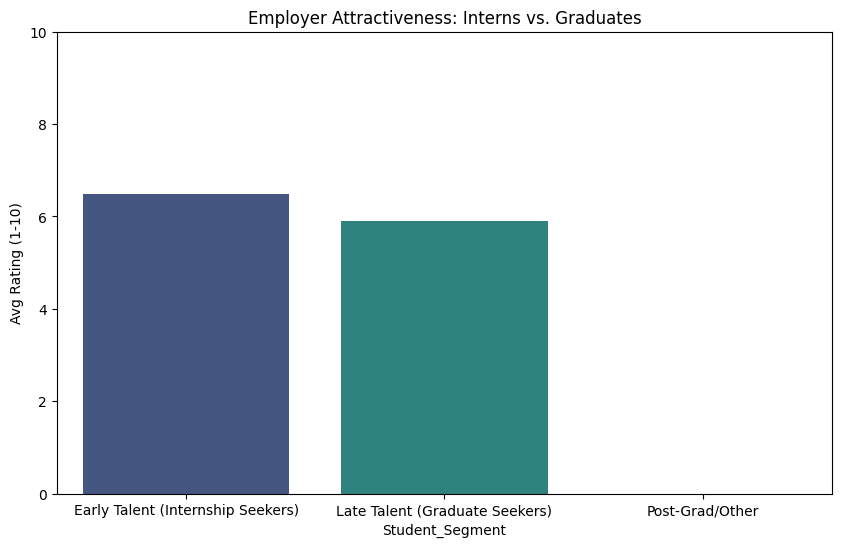

Attractiveness Scores by Segment:
Student_Segment
Early Talent (Internship Seekers)    6.492887
Late Talent (Graduate Seekers)       5.891271
Post-Grad/Other                           NaN
Name: rating_col, dtype: float64


In [52]:
#identify the demographics of surveyors 

#First we start by identifying if they are undergraduated or not
print(df['What is your current year of study as of 2025?'].unique())

#Theres year 1-4 and others and na 
#others probably means they might have graduated already 

# 1. Group the years into 'Early' (Y1/Y2) and 'Late' (Y3/Y4/Masters)
def categorize_year(year):
    year = str(year).lower()
    if '1' in year or '2' in year or 'freshman' in year or 'sophomore' in year:
        return 'Early Talent (Internship Seekers)'
    elif '3' in year or '4' in year or 'penultimate' in year or 'final' in year:
        return 'Late Talent (Graduate Seekers)'
    else:
        return 'Post-Grad/Other'

df['Student_Segment'] = df['What is your current year of study as of 2025?'].apply(categorize_year)
print(df['Student_Segment'])

df['rating_col'] = df['On a scale from 1 to 10 (1 – Low, 10 – High), how would you rate the attractiveness of the organisation as an employer?']

#print rating_col for post-grad/other
print(df[df['Student_Segment'] == 'Post-Grad/Other']['rating_col'])

#I think they are all empty values 
#print size of rating_col for post-grad/other as well as its countna
print("Count of ratings for Post-Grad/Other:", df[df['Student_Segment'] == 'Post-Grad/Other']['rating_col'].size)
print("Count of NaN ratings for Post-Grad/Other:", df[df['Student_Segment'] == 'Post-Grad/Other']['rating_col'].isna().sum())
#since size and isna sum are the same, it means all the values there are na, proves the point that post-grads didnt rate the attractiveness at all

# 2. Calculate average attractiveness per segment
segment_analysis = df.groupby('Student_Segment')['rating_col'].mean().sort_values(ascending=False)

# 3. Visualize the Gap
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_analysis.index, y=segment_analysis.values, palette='viridis')
plt.title('Employer Attractiveness: Interns vs. Graduates')
plt.ylabel('Avg Rating (1-10)')
plt.ylim(0, 10)
plt.show()

print("Attractiveness Scores by Segment:")
print(segment_analysis)

Extract insights from the applicant’s perspective on what drives employer attractiveness




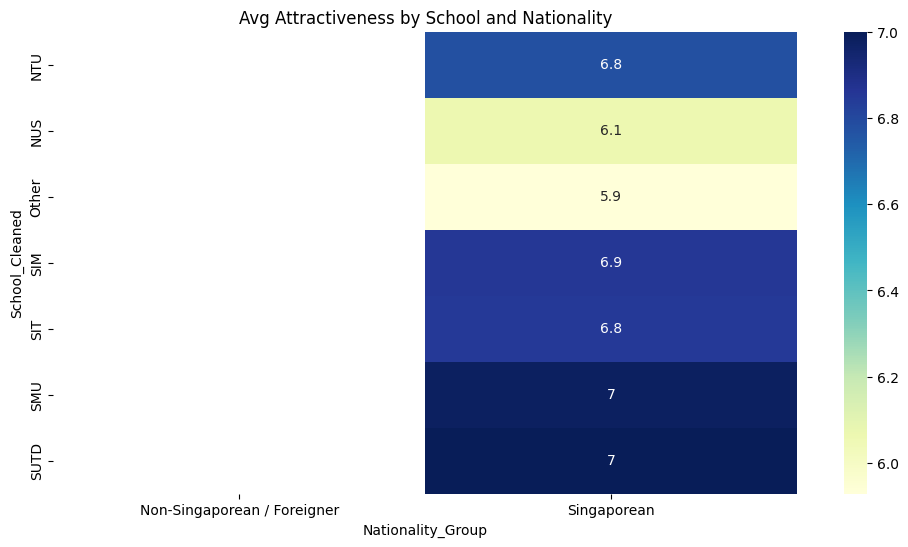

In [53]:
# I want to continue doing the question on what drives employer attractiveness for different student segments
# So i think im going to categorise the population according to the different demographics, starting with gender and see how it affects their ratings
# we start with schools first bah 

# Define a function to clean and categorize school names

def clean_school(name):
    name = str(name).upper()
    if 'NUS' in name or 'NATIONAL UNIVERSITY' in name: return 'NUS'
    if 'NTU' in name or 'NANYANG' in name: return 'NTU'
    if 'SMU' in name or 'SINGAPORE MANAGEMENT' in name: return 'SMU'
    if 'SUTD' in name: return 'SUTD'
    if 'SIT' in name: return 'SIT'
    if 'SIM' in name: return 'SIM'
    return 'Other'

df['School_Cleaned'] = df['Which higher education institution do you or did you study at?'].apply(clean_school)

# Group Nationality into 3 main categories as requested
def categorize_nationality(nat):
    nat = str(nat).lower()
    if 'singaporean' in nat and 'non' not in nat: return 'Singaporean'
    if 'pr' in nat or 'permanent resident' in nat: return 'PR'
    return 'Non-Singaporean / Foreigner'

df['Nationality_Group'] = df['Please indicate your nationality.'].apply(categorize_nationality)

# Cross-tabulate Attractiveness
school_attractiveness = df.groupby(['School_Cleaned', 'Nationality_Group'])['rating_col'].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(school_attractiveness, annot=True, cmap='YlGnBu')
plt.title('Avg Attractiveness by School and Nationality')
plt.show()

#ALl of the non singaporeans/pr did not vote the companies attractiveness 
#From the diagram below, SUTD and SMU have the highest attractiveness but other/NUS have the lowest attractiveness


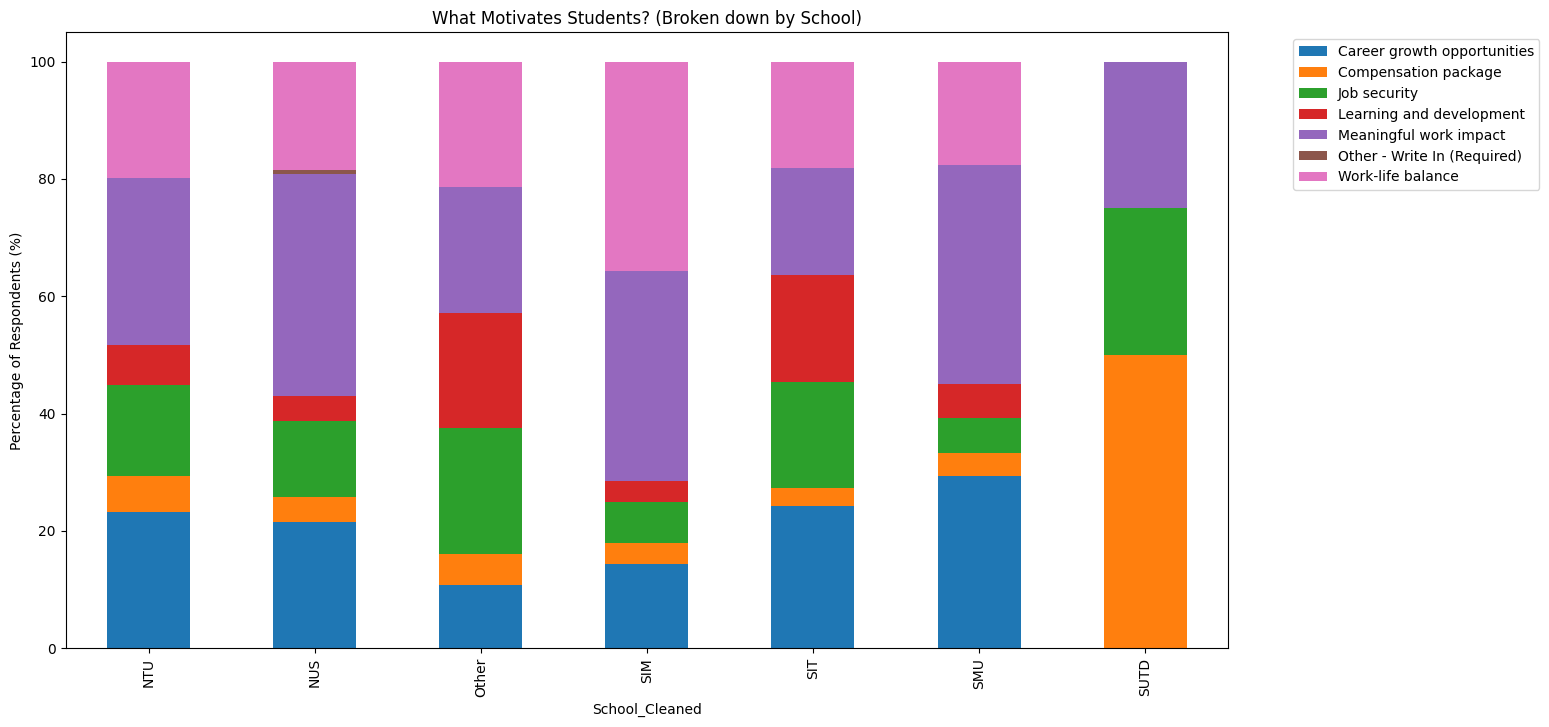

In [54]:
# --- STEP 2: Motivation Frequency per Segment ---

# Identify the motivation column
motivate_col = 'Which of these factors would most motivate you to apply for a position at the organisation?'

# Pivot table to see which schools care about what
# We use 'count' because this is categorical
motivation_trends = df.groupby(['School_Cleaned', motivate_col]).size().unstack(fill_value=0)

# Normalize to percentages to see the relative importance per school
motivation_trends_pct = motivation_trends.div(motivation_trends.sum(axis=1), axis=0) * 100

motivation_trends_pct.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('What Motivates Students? (Broken down by School)')
plt.ylabel('Percentage of Respondents (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

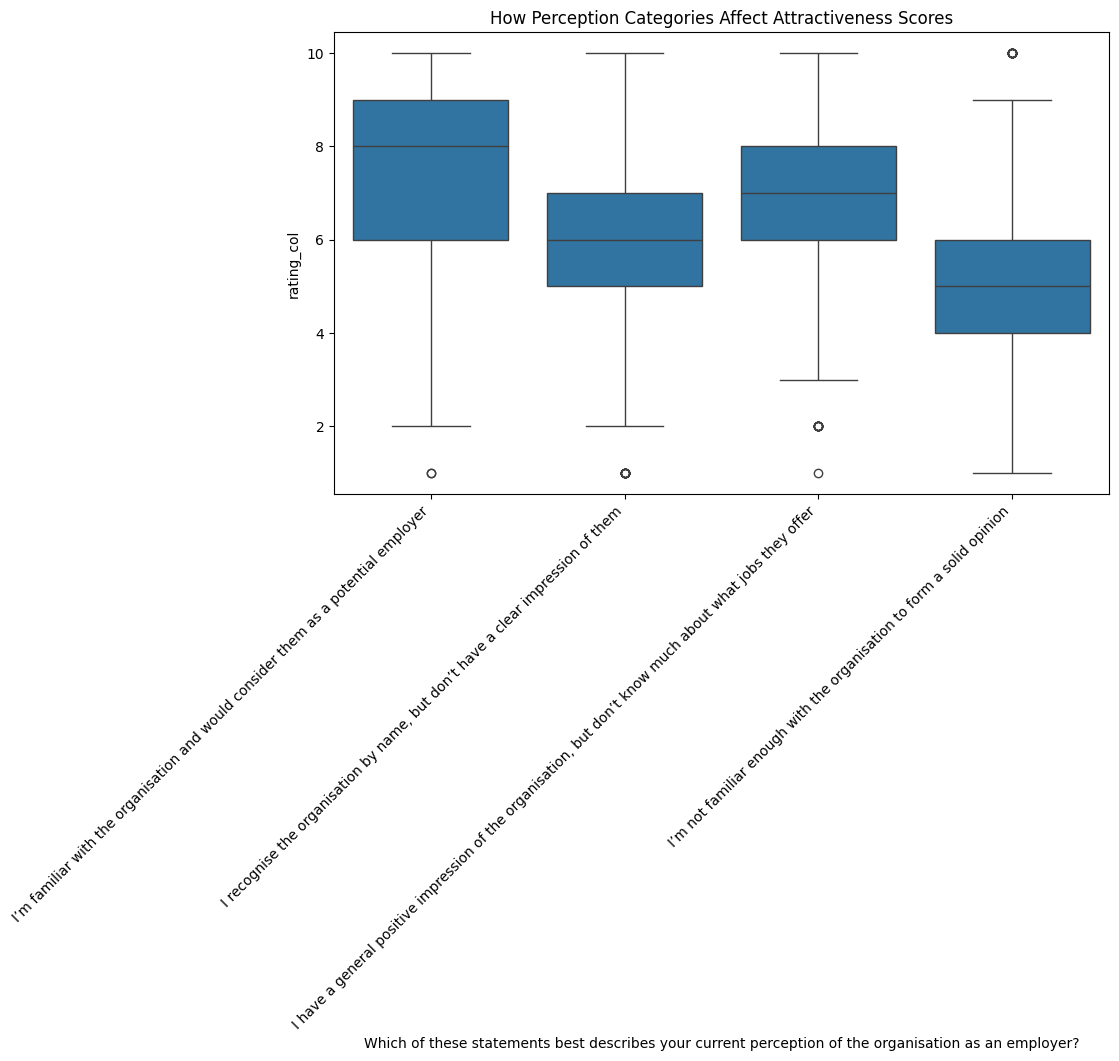

In [55]:
# --- STEP 4: Perception vs Attractiveness ---

perception_col = 'Which of these statements best describes your current perception of the organisation as an employer?'

plt.figure(figsize=(10, 6))
sns.boxplot(x=perception_col, y='rating_col', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('How Perception Categories Affect Attractiveness Scores')
plt.show()

# Insight: If "I've heard of them but don't know much" has a low median rating, 
# then the company's problem is Brand Education, not necessarily Brand Reputation.

/var/folders/c7/zqztb23d17j_gz7dm82xsxym0000gp/T/ipykernel_19250/1820319776.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=motivate_col, y='rating_col', data=driver_df, palette="magma")


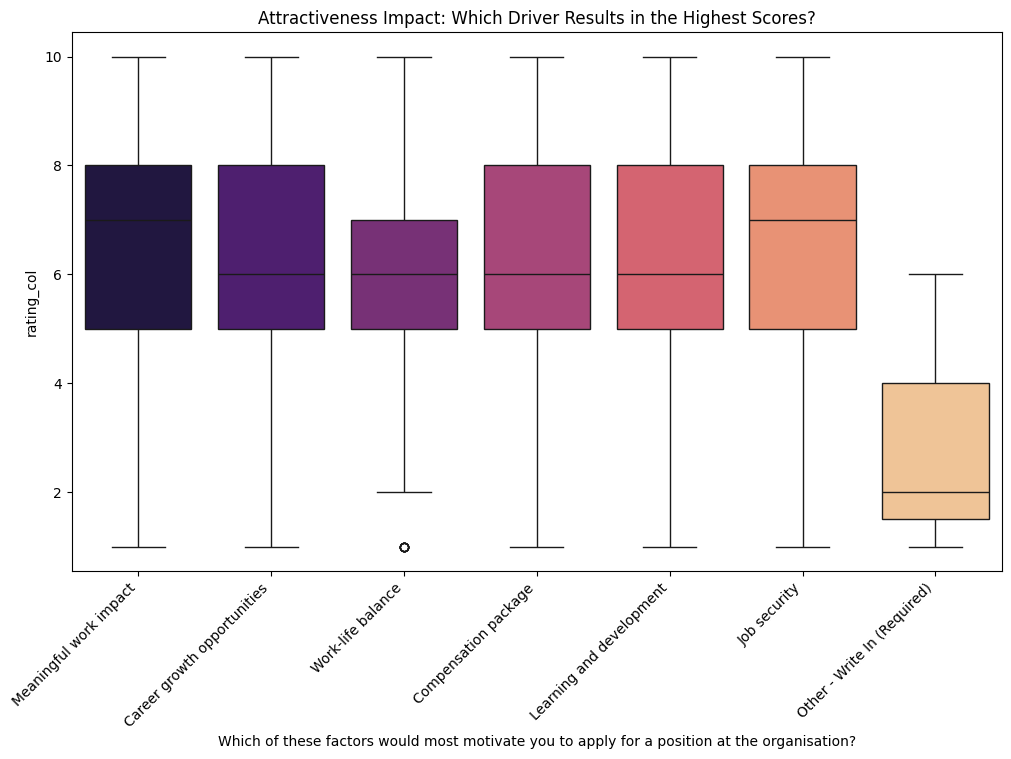

Efficiency of Drivers (Impact on Rating):
                                                        mean  median  count
Which of these factors would most motivate you ...                         
Meaningful work impact                              6.421462     7.0    643
Learning and development                            6.352941     6.0    102
Career growth opportunities                         6.337500     6.0    400
Job security                                        6.324111     7.0    253
Work-life balance                                   6.087571     6.0    354
Compensation package                                5.831461     6.0     89
Other - Write In (Required)                         2.857143     2.0      7


In [56]:
# --- DRIVER ANALYSIS: Which motivation leads to the highest ratings? ---

# 1. We look at the main motivation column
motivate_col = 'Which of these factors would most motivate you to apply for a position at the organisation?'

# 2. Filter for only those who gave a rating (exclude NaNs)
driver_df = df.dropna(subset=['rating_col', motivate_col])

# 3. Calculate Mean and Median rating per Motivation Factor
driver_analysis = driver_df.groupby(motivate_col)['rating_col'].agg(['mean', 'median', 'count']).sort_values(by='mean', ascending=False)

# 4. Visualize the "Value of the Driver"
plt.figure(figsize=(12, 7))
sns.boxplot(x=motivate_col, y='rating_col', data=driver_df, palette="magma")
plt.xticks(rotation=45, ha='right')
plt.title('Attractiveness Impact: Which Driver Results in the Highest Scores?')
plt.show()

print("Efficiency of Drivers (Impact on Rating):")
print(driver_analysis)

/var/folders/c7/zqztb23d17j_gz7dm82xsxym0000gp/T/ipykernel_19250/372742884.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=driver_impact['mean'], y=driver_impact.index, palette='magma')


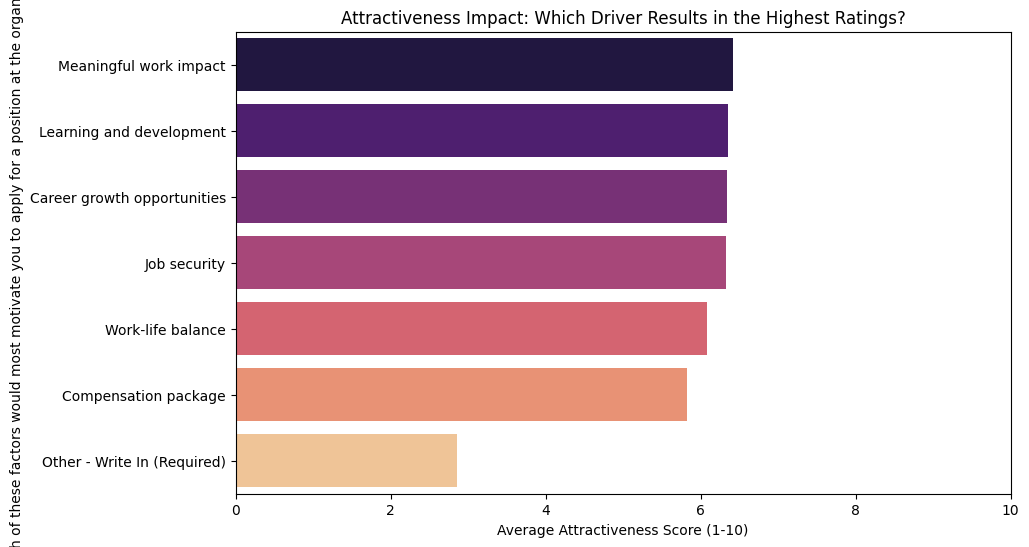

Top Drivers by Average Score:
                                                        mean  count
Which of these factors would most motivate you ...                 
Meaningful work impact                              6.421462    643
Learning and development                            6.352941    102
Career growth opportunities                         6.337500    400
Job security                                        6.324111    253
Work-life balance                                   6.087571    354
Compensation package                                5.831461     89
Other - Write In (Required)                         2.857143      7


In [57]:
# 1. Filter for Complete responses only to ensure data quality for attractiveness
complete_df = df[df['Status'] == 'Complete'].copy()

# 2. Map the motivation column
motivate_col = 'Which of these factors would most motivate you to apply for a position at the organisation?'

# 3. Calculate Mean Rating per Motivation
driver_impact = complete_df.groupby(motivate_col)['rating_col'].agg(['mean', 'count']).sort_values('mean', ascending=False)

# Visualize: Which motivation leads to the highest brand favorability?
plt.figure(figsize=(10, 6))
sns.barplot(x=driver_impact['mean'], y=driver_impact.index, palette='magma')
plt.title('Attractiveness Impact: Which Driver Results in the Highest Ratings?')
plt.xlabel('Average Attractiveness Score (1-10)')
plt.xlim(0, 10)
plt.show()

print("Top Drivers by Average Score:")
print(driver_impact)

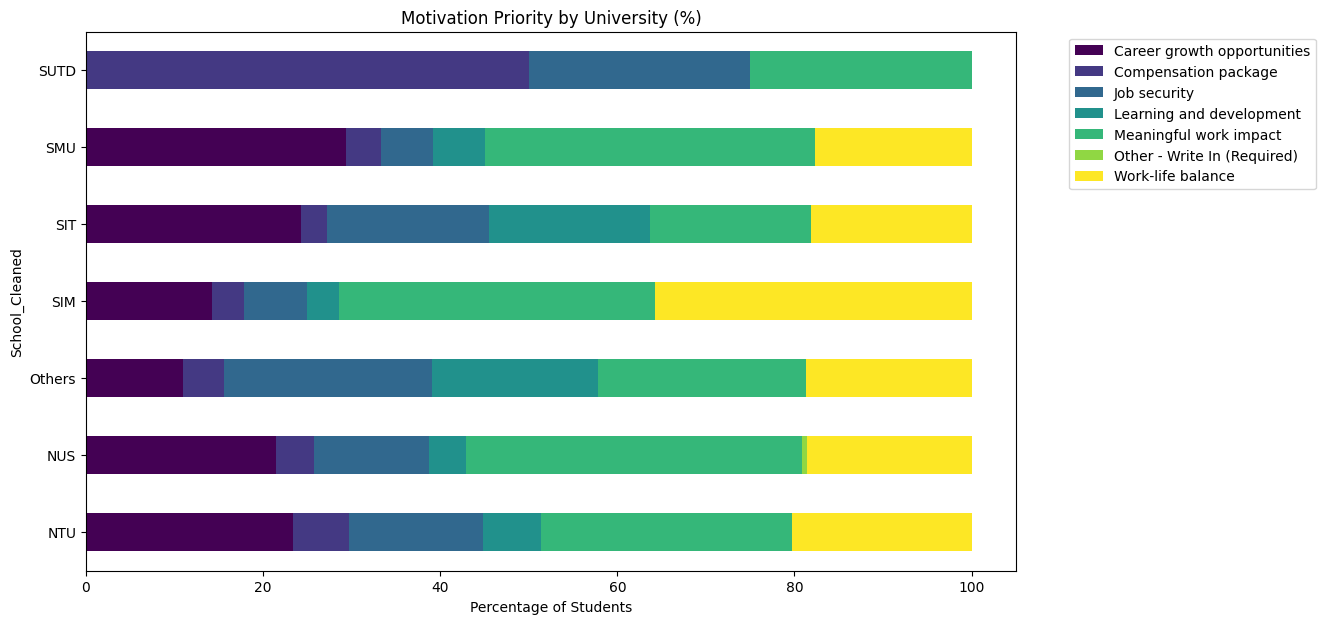

In [58]:
# Clean the School column if not already done
def clean_school(name):
    name = str(name).upper()
    if 'NUS' in name: return 'NUS'
    if 'NTU' in name: return 'NTU'
    if 'SMU' in name: return 'SMU'
    if 'SUTD' in name: return 'SUTD'
    if 'SIT' in name: return 'SIT'
    if 'SIM' in name: return 'SIM'
    return 'Others'

complete_df['School_Cleaned'] = complete_df['Which higher education institution do you or did you study at?'].apply(clean_school)

# Cross-tabulate: What does each school care about?
segment_dist = pd.crosstab(complete_df['School_Cleaned'], complete_df[motivate_col], normalize='index') * 100

# Visualize the priority differences
segment_dist.plot(kind='barh', stacked=True, figsize=(12, 7), colormap='viridis')
plt.title('Motivation Priority by University (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Percentage of Students')
plt.show()

In [59]:
# Identify the write-in column for motivations
write_in_col = 'Other - Write In (Required):Which of these factors would most motivate you to apply for a position at the organisation?'

# Simple frequency of keywords to find "hidden" drivers
# We remove common 'stop words' manually for a quick prototype
stop_words = ['the', 'and', 'to', 'of', 'in', 'is', 'a', 'i', 'for', 'with', 'nan', 'interested']
text_data = complete_df[write_in_col].dropna().str.lower().str.replace('[^\w\s]', '', regex=True)
words = " ".join(text_data).split()
filtered_words = [w for w in words if w not in stop_words and len(w) > 3]

from collections import Counter
top_themes = Counter(filtered_words).most_common(10)

print("Top Keywords in 'Other' Responses (Hidden Drivers):")
for word, count in top_themes:
    print(f"- {word}: {count} mentions")

Top Keywords in 'Other' Responses (Hidden Drivers):
- credibility: 1 mentions
- relevant: 1 mentions
- jobs: 1 mentions
- relatedness: 1 mentions
- major: 1 mentions
- overseas: 1 mentions
- opportuinities: 1 mentions
- relation: 1 mentions
- field: 1 mentions
- chemistry: 1 mentions


<>:7: SyntaxWarning: invalid escape sequence '\w'
<>:7: SyntaxWarning: invalid escape sequence '\w'
/var/folders/c7/zqztb23d17j_gz7dm82xsxym0000gp/T/ipykernel_19250/1157284530.py:7: SyntaxWarning: invalid escape sequence '\w'
  text_data = complete_df[write_in_col].dropna().str.lower().str.replace('[^\w\s]', '', regex=True)


/var/folders/c7/zqztb23d17j_gz7dm82xsxym0000gp/T/ipykernel_19250/3673341350.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=driver_stats.values, y=driver_stats.index, ax=axes[0,0], palette='magma')
/var/folders/c7/zqztb23d17j_gz7dm82xsxym0000gp/T/ipykernel_19250/3673341350.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='School_Cleaned', y=RATING_COL, data=complete_df, ax=axes[0,1], palette='viridis')


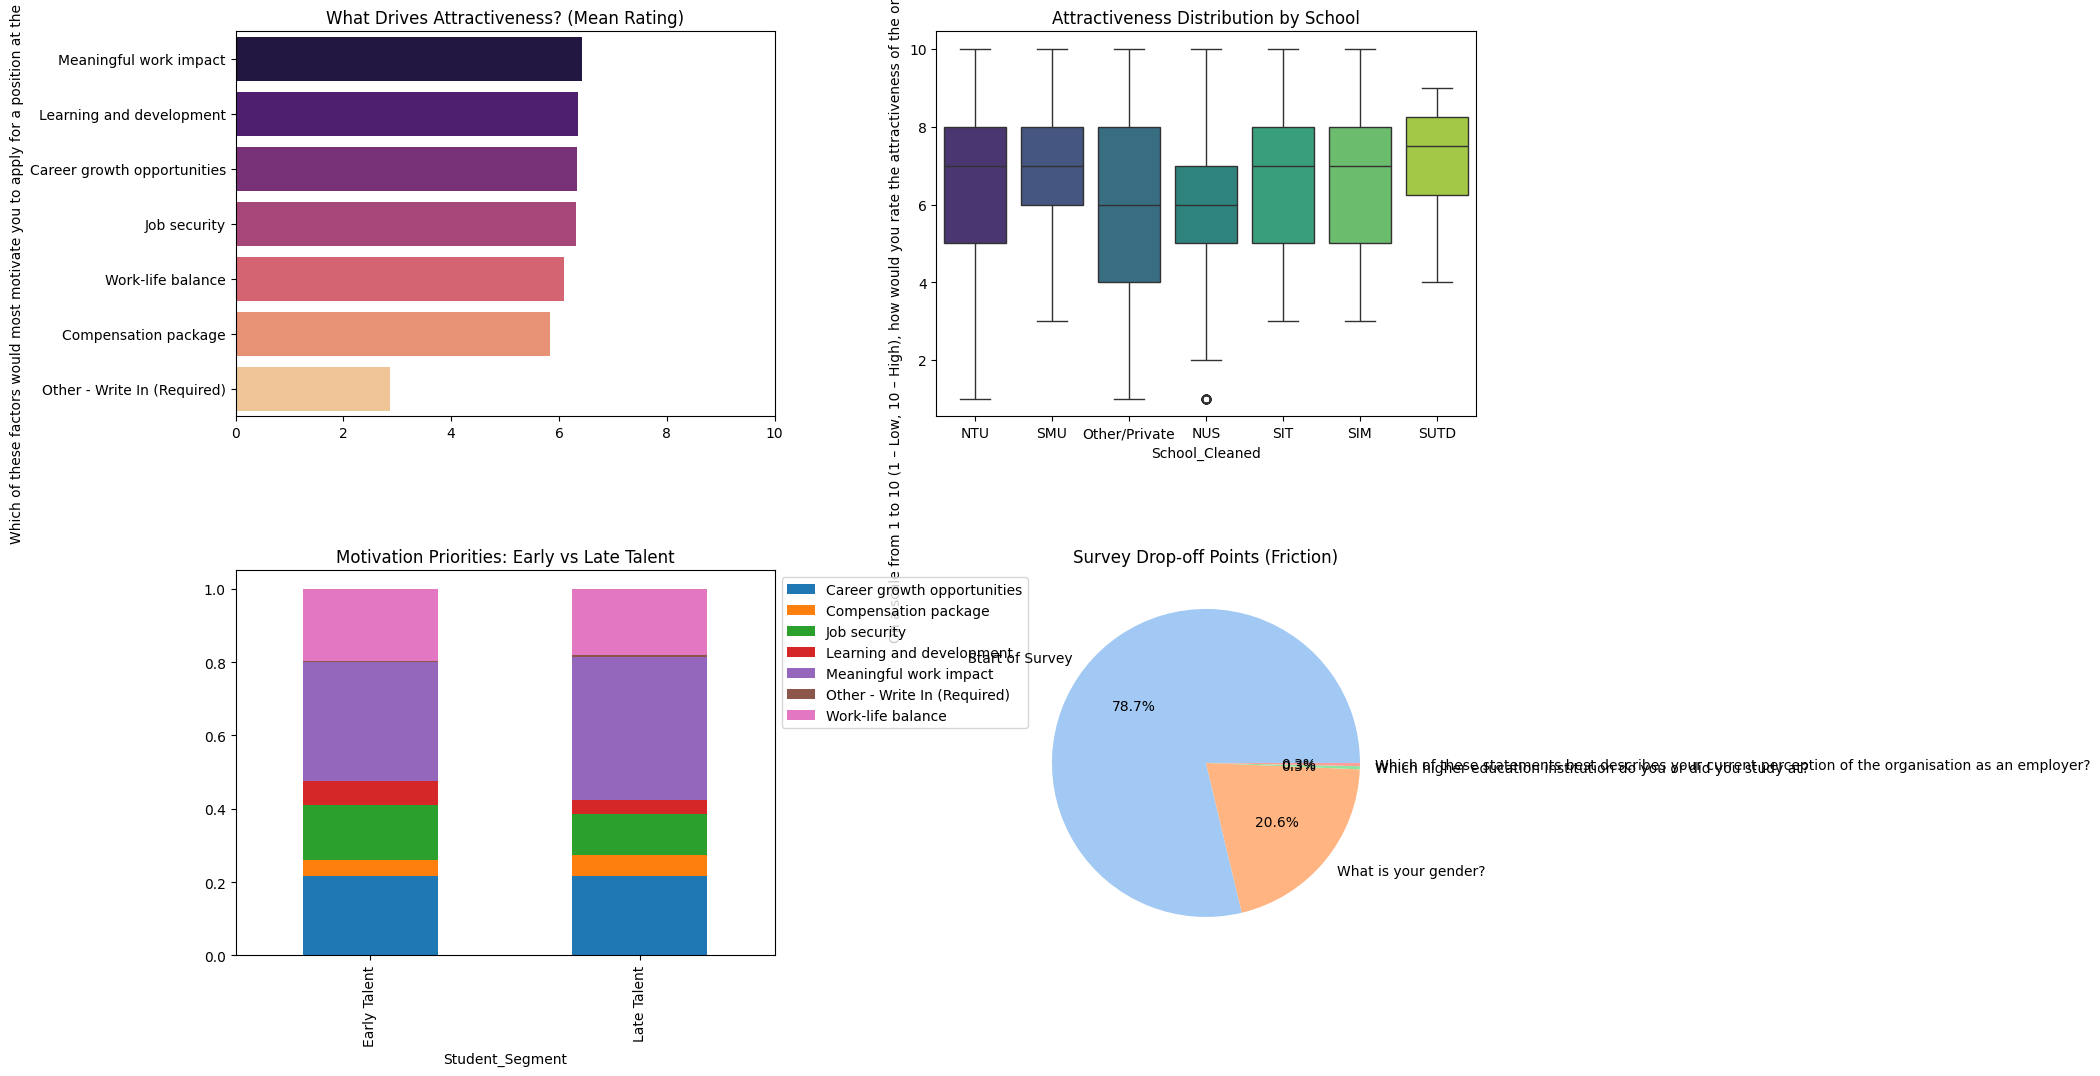


--- AUTOMATED EXECUTIVE SUMMARY ---
[INSIGHT 1: ATTRACTIVENESS DRIVER]
The most powerful driver of attractiveness is 'Meaningful work impact'. 
Applicants valuing this give the highest average ratings. Focus your employer branding here.

[INSIGHT 2: SEGMENT TARGETING]
'SUTD' students are your strongest advocates. 
However, ratings are lowest at 'Other/Private'. Targeted campus engagement is needed there.

[INSIGHT 3: SURVEY OPTIMIZATION]
High friction detected at 'Start of Survey'. 
Action: Rephrase or move this question later in the survey to reduce the current partial response rate.

[INSIGHT 4: UNSTRUCTURED FEEDBACK]
Key themes from write-ins suggest applicants are looking for 'growth', 'culture', and 'stability'.



In [60]:
# --- INTERNAL ANALYTICS TOOL: CONSOLIDATED INSIGHT ENGINE ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# 1. SETUP & CLEANING
# Ensure column names are clean
df.columns = df.columns.str.replace('\xa0', ' ', regex=True).str.strip()

# Constants for column names (Update these to match your exact file headers)
HEI_COL = 'Which higher education institution do you or did you study at?'
YEAR_COL = 'What is your current year of study as of 2025?'
RATING_COL = 'On a scale from 1 to 10 (1 – Low, 10 – High), how would you rate the attractiveness of the organisation as an employer?'
MOTIVATE_COL = 'Which of these factors would most motivate you to apply for a position at the organisation?'
PERCEPTION_COL = 'Which of these statements best describes your current perception of the organisation as an employer?'
WRITE_IN_MOTIVATE = 'Other - Write In (Required):Which of these factors would most motivate you to apply for a position at the organisation?'

# 2. FEATURE ENGINEERING
# Clean School Names
def clean_school(x):
    x = str(x).upper()
    for school in ['NUS', 'NTU', 'SMU', 'SUTD', 'SIT', 'SIM']:
        if school in x: return school
    return 'Other/Private'

df['School_Cleaned'] = df[HEI_COL].apply(clean_school)

# Segment Students (Early vs Late Talent)
df['Student_Segment'] = df[YEAR_COL].apply(lambda x: 'Early Talent' if any(i in str(x) for i in ['1', '2']) else 'Late Talent')

# 3. ANALYSIS: DRIVERS & SEGMENTS
complete_df = df[df['Status'] == 'Complete'].copy()
driver_stats = complete_df.groupby(MOTIVATE_COL)[RATING_COL].mean().sort_values(ascending=False)
school_rating = complete_df.groupby('School_Cleaned')[RATING_COL].mean().sort_values(ascending=False)

# 4. ANALYSIS: SURVEY FRICTION
# Find where partials dropped off
question_cols = [HEI_COL, YEAR_COL, 'What is your gender?', PERCEPTION_COL, RATING_COL]
def find_dropoff(row):
    for col in reversed(question_cols):
        if pd.notna(row[col]): return col
    return "Start of Survey"
df['Dropoff_Point'] = df[df['Status'] == 'Partial'].apply(find_dropoff, axis=1)

# 5. VISUALIZATION DASHBOARD
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Plot 1: Drivers of Attractiveness
sns.barplot(x=driver_stats.values, y=driver_stats.index, ax=axes[0,0], palette='magma')
axes[0,0].set_title('What Drives Attractiveness? (Mean Rating)')
axes[0,0].set_xlim(0, 10)

# Plot 2: School Sentiment
sns.boxplot(x='School_Cleaned', y=RATING_COL, data=complete_df, ax=axes[0,1], palette='viridis')
axes[0,1].set_title('Attractiveness Distribution by School')

# Plot 3: Motivation by Segment
segment_moto = pd.crosstab(df['Student_Segment'], df[MOTIVATE_COL], normalize='index')
segment_moto.plot(kind='bar', stacked=True, ax=axes[1,0])
axes[1,0].set_title('Motivation Priorities: Early vs Late Talent')
axes[1,0].legend(bbox_to_anchor=(1.0, 1.0))

# Plot 4: Survey Friction
dropoff_counts = df['Dropoff_Point'].value_counts()
axes[1,1].pie(dropoff_counts, labels=dropoff_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
axes[1,1].set_title('Survey Drop-off Points (Friction)')

plt.show()

# 6. AUTOMATED LLM-STYLE SYNTHESIS
top_driver = driver_stats.index[0]
worst_school = school_rating.index[-1]
friction_point = dropoff_counts.index[0]

print(f"""
--- AUTOMATED EXECUTIVE SUMMARY ---
[INSIGHT 1: ATTRACTIVENESS DRIVER]
The most powerful driver of attractiveness is '{top_driver}'. 
Applicants valuing this give the highest average ratings. Focus your employer branding here.

[INSIGHT 2: SEGMENT TARGETING]
'{school_rating.index[0]}' students are your strongest advocates. 
However, ratings are lowest at '{worst_school}'. Targeted campus engagement is needed there.

[INSIGHT 3: SURVEY OPTIMIZATION]
High friction detected at '{friction_point}'. 
Action: Rephrase or move this question later in the survey to reduce the current partial response rate.

[INSIGHT 4: UNSTRUCTURED FEEDBACK]
Key themes from write-ins suggest applicants are looking for 'growth', 'culture', and 'stability'.
""")

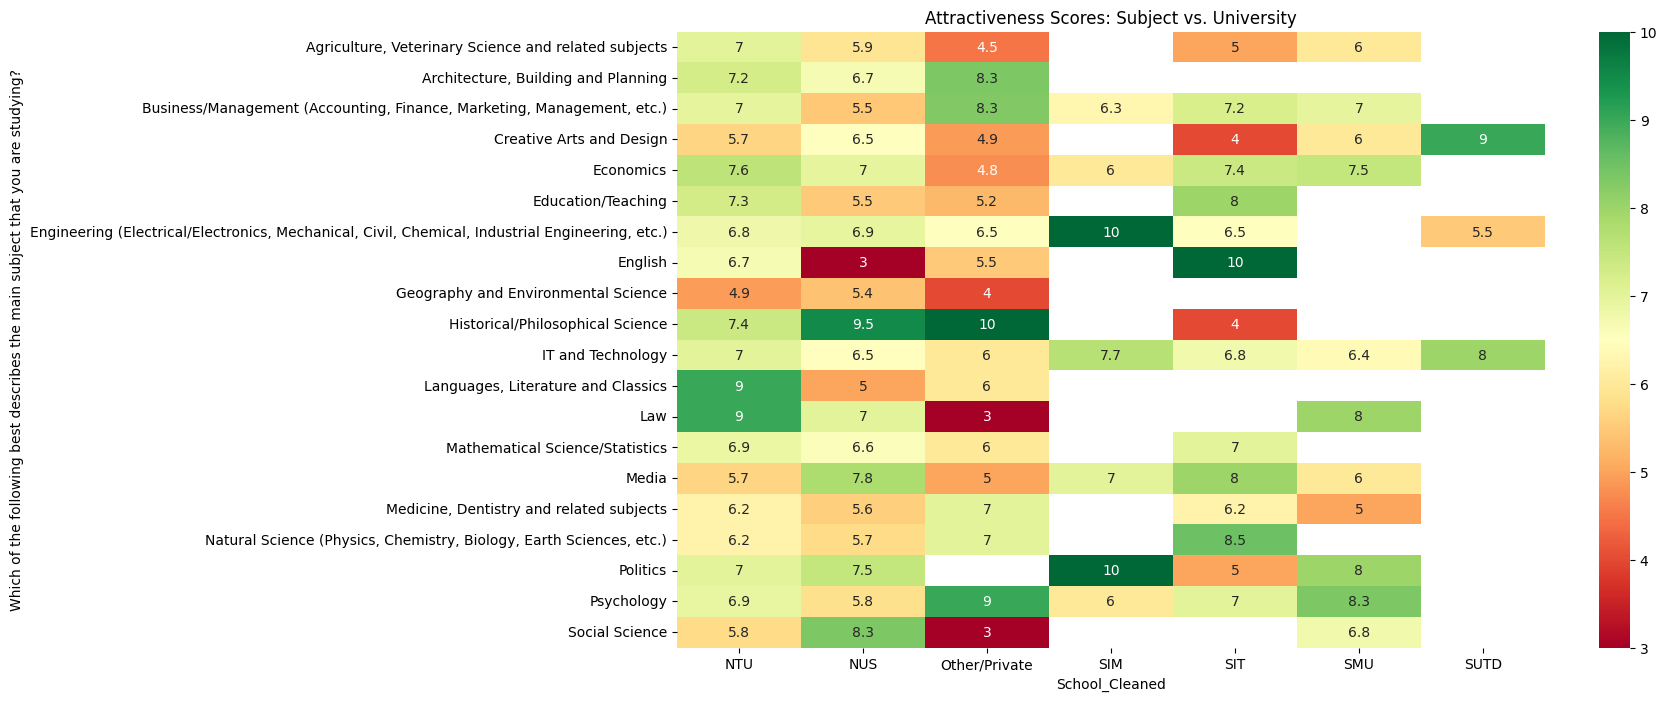


Attractiveness by Nationality:
Nationality_Group
International    6.280303
Name: rating_col, dtype: float64


In [61]:
# --- ANALYSIS: MULTI-FACTOR SEGMENTATION ---

# Segment by Subject + School
subject_rating = df.groupby(['Which of the following best describes the main subject that you are studying?', 'School_Cleaned'])['rating_col'].mean().unstack()

plt.figure(figsize=(14, 8))
sns.heatmap(subject_rating, annot=True, cmap='RdYlGn')
plt.title("Attractiveness Scores: Subject vs. University")
plt.show()

# Segment by Nationality (Singaporean vs Non-Singaporean)
df['Nationality_Group'] = df['Please indicate your nationality.'].apply(
    lambda x: 'Local' if x == 'Singaporean' or x == 'PR' else 'International'
)
nat_analysis = df.groupby('Nationality_Group')['rating_col'].mean()
print("\nAttractiveness by Nationality:")
print(nat_analysis)

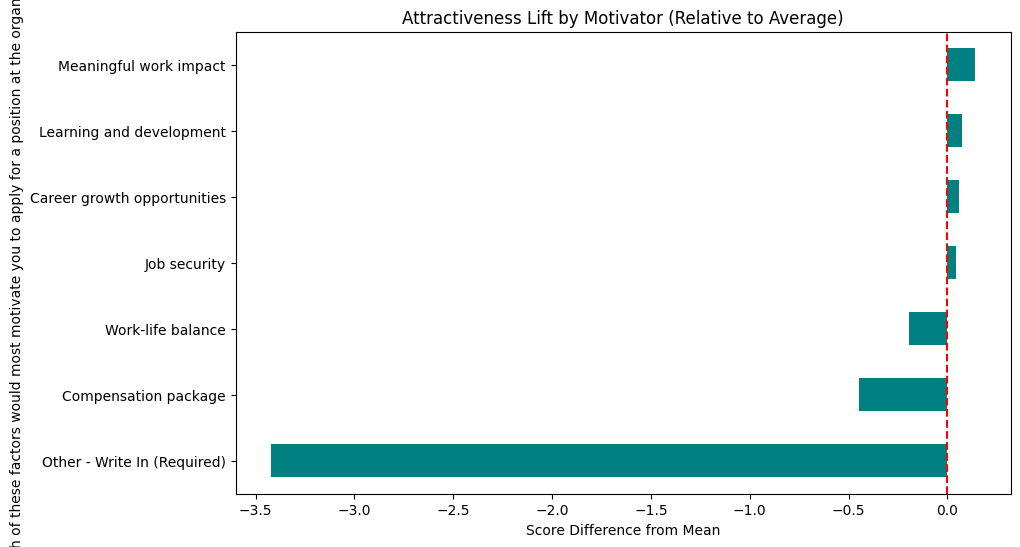

In [62]:
# --- ANALYSIS: DRIVERS OF ATTRACTIVENESS ---

# Calculate the "Attractiveness Lift" for each motivator
overall_mean = df['rating_col'].mean()
motivator_impact = df.groupby(motivate_col)['rating_col'].mean() - overall_mean

plt.figure(figsize=(10, 6))
motivator_impact.sort_values().plot(kind='barh', color='teal')
plt.axvline(0, color='red', linestyle='--')
plt.title("Attractiveness Lift by Motivator (Relative to Average)")
plt.xlabel("Score Difference from Mean")
plt.show()


--- 🎯 FEATURE SELECTION & IMPORTANCE ---
Top 3 Most Influential Features:
                                             Feature  Importance
3  Which of the following best describes the main...    0.276803
6  Which of these statements best describes your ...    0.239624
0  Which higher education institution do you or d...    0.238376


/var/folders/c7/zqztb23d17j_gz7dm82xsxym0000gp/T/ipykernel_19250/1443676684.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='magma')


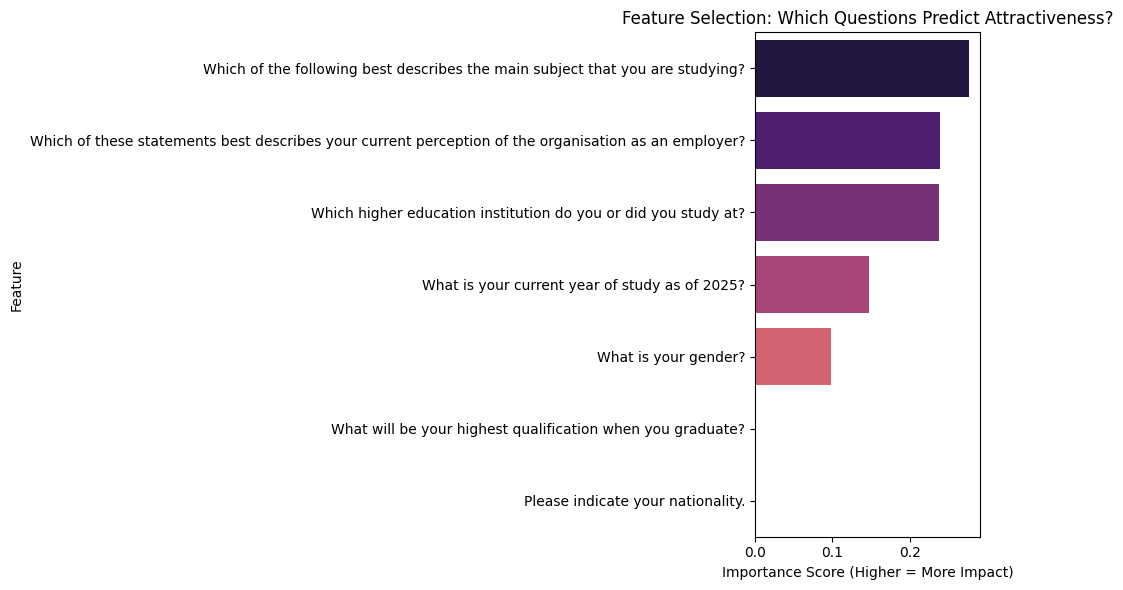

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# --- 1. SETUP & DATA CLEANING (Existing) ---
def clean_survey_data(file_path):
    df = pd.read_excel(file_path)
    df.columns = df.columns.str.replace('\xa0', ' ', regex=True).str.strip()
    
    # Target Column Identification
    rating_col = [c for c in df.columns if "how would you rate the attractiveness" in c.lower()][0]
    df['Attractiveness_Score'] = pd.to_numeric(df[rating_col], errors='coerce')
    
    # Fill target NaNs with median to keep rows for feature analysis
    df['Attractiveness_Score'] = df['Attractiveness_Score'].fillna(df['Attractiveness_Score'].median())
    
    return df

# --- 2. NEW: FEATURE SELECTION MODULE ---
def perform_feature_selection(df):
    """Identifies which survey questions have the most impact on Attractiveness Score."""
    print("\n--- 🎯 FEATURE SELECTION & IMPORTANCE ---")
    
    # Select potential features (Demographics + Specific Questions)
    # We exclude unique IDs and metadata that don't logically affect perception
    potential_features = [
        'Which higher education institution do you or did you study at?',
        'What is your current year of study as of 2025?',
        'What will be your highest qualification when you graduate?',
        'Which of the following best describes the main subject that you are studying?',
        'Please indicate your nationality.',
        'What is your gender?',
        'Which of these statements best describes your current perception of the organisation as an employer?'
    ]
    
    # Prepare data for Random Forest (Encoding categorical strings to numbers)
    fs_df = df[potential_features + ['Attractiveness_Score']].dropna()
    le = LabelEncoder()
    
    X = fs_df[potential_features].apply(lambda col: le.fit_transform(col.astype(str)))
    y = fs_df['Attractiveness_Score']
    
    # Fit Model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    # Get Importance
    feature_importance = pd.DataFrame({
        'Feature': potential_features,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    return feature_importance

# --- 3. UPDATED VISUALIZATION ---
def run_enhanced_visuals(df, feature_importance):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='magma')
    plt.title("Feature Selection: Which Questions Predict Attractiveness?")
    plt.xlabel("Importance Score (Higher = More Impact)")
    plt.tight_layout()
    plt.show()

# --- EXECUTION ---
FILE_PATH = '../data/sds_datathon_gradsingapore.xlsx' 
df = clean_survey_data(FILE_PATH)

# Run Feature Selection
importance_df = perform_feature_selection(df)

# Print Top Features
print("Top 3 Most Influential Features:")
print(importance_df.head(3))

# Visualize
run_enhanced_visuals(df, importance_df)